In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# GHO API endpoint
url = "https://ghoapi.azureedge.net/api/"

# Measles indicators
indicators = {
    "MCV2": "Measles-containing-vaccine second-dose (MCV2) immunization coverage",
    "WHS8_110": "Measles-containing-vaccine first-dose (MCV1) immunization coverage",
    "WHS3_62": "Measles - number of reported cases",
    "vmsl": "Measles immunization coverage among one-year-olds (%)"
}

def get_gho_data(indicator_code):
    """Retrieve data for a specific indicator from GHO API"""
    try:
        response = requests.get(f"{url}{indicator_code}")
        response.raise_for_status()
        data = response.json()
        
        # Convert to DataFrame
        df = pd.DataFrame(data['value'])
        return df
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {indicator_code}: {e}")
        return None

In [7]:
# Retrieve data for all indicators
all_data = {}

for code, description in indicators.items():
    print(f"Retrieving data for {code}: {description}")
    df = get_gho_data(code)
    if df is not None and not df.empty:
        all_data[code] = df
        print(f"Retrieved {len(df)} records for {code}")

# Get country information
countries_df = get_gho_data("RegionCountry")

Retrieving data for MCV2: Measles-containing-vaccine second-dose (MCV2) immunization coverage
Retrieved 5106 records for MCV2
Retrieving data for WHS8_110: Measles-containing-vaccine first-dose (MCV1) immunization coverage
Retrieved 5106 records for WHS8_110
Retrieving data for WHS3_62: Measles - number of reported cases
Retrieved 9742 records for WHS3_62
Retrieving data for WHS2_168: Distribution of causes of death among children aged <5 years (%) - Measles
Retrieving data for vmsl: Measles immunization coverage among one-year-olds (%)
Retrieved 14858 records for vmsl


In [10]:
output_dir = "gho_measles_data"
os.makedirs(output_dir, exist_ok=True)

# Save all data to a single Excel file with multiple sheets
try:
    excel_filename = "all_measles_data.xlsx"
    excel_filepath = os.path.join(output_dir, excel_filename)
    
    with pd.ExcelWriter(excel_filepath, engine='openpyxl') as writer:
        for indicator_code, df in all_data.items():
            # Shorten sheet name if needed (Excel has 31-character limit)
            sheet_name = indicator_code[:31]
            df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # Add countries sheet if available
        if 'countries_df' in locals() and countries_df is not None:
            countries_df.to_excel(writer, sheet_name='Countries', index=False)
    
    print(f"✓ Saved all data to {excel_filename}")
    
except ImportError:
    print("openpyxl not installed. Install with: pip install openpyxl")
except Exception as e:
    print(f"Error saving Excel file: {e}")

✓ Saved all data to all_measles_data.xlsx


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def analyze_measles_temporal(all_data, countries_df):
    """Analyze measles data with proper time dimension handling"""
    
    # Extract and clean each dataset
    datasets = {}
    
    # Process MCV2 data
    if 'MCV2' in all_data:
        mcv2 = all_data['MCV2'].copy()
        mcv2 = mcv2[['SpatialDim', 'TimeDim', 'NumericValue']].rename(
            columns={'NumericValue': 'MCV2_Coverage'}
        )
        datasets['MCV2'] = mcv2
    
    # Process MCV1 data (WHS8_110)
    if 'WHS8_110' in all_data:
        mcv1 = all_data['WHS8_110'].copy()
        mcv1 = mcv1[['SpatialDim', 'TimeDim', 'NumericValue']].rename(
            columns={'NumericValue': 'MCV1_Coverage'}
        )
        datasets['MCV1'] = mcv1
    
    # Process Measles Cases (WHS3_62)
    if 'WHS3_62' in all_data:
        cases = all_data['WHS3_62'].copy()
        cases = cases[['SpatialDim', 'TimeDim', 'NumericValue']].rename(
            columns={'NumericValue': 'Measles_Cases'}
        )
        datasets['Cases'] = cases
    
    # Merge all datasets
    merged_df = None
    
    for name, df in datasets.items():
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.merge(df, on=['SpatialDim', 'TimeDim'], how='outer')
    
    # Add country names
    if countries_df is not None:
        country_map = countries_df[['CountryCode', 'CountryName']].drop_duplicates()
        merged_df = merged_df.merge(
            country_map, 
            left_on='SpatialDim', 
            right_on='CountryCode', 
            how='left'
        )
    
    return merged_df

# Perform the analysis
cleaned_data = analyze_measles_temporal(all_data, countries_df)

print("=== DATA OVERVIEW ===")
print(f"Dataset shape: {cleaned_data.shape}")
print(f"Time range: {cleaned_data['TimeDim'].min()} - {cleaned_data['TimeDim'].max()}")
print(f"Number of countries: {cleaned_data['SpatialDim'].nunique()}")
print(f"\nColumns: {cleaned_data.columns.tolist()}")
print(f"\nFirst few rows:")
print(cleaned_data.head())

=== DATA OVERVIEW ===
Dataset shape: (10084, 7)
Time range: 1974 - 2024
Number of countries: 225

Columns: ['SpatialDim', 'TimeDim', 'MCV2_Coverage', 'MCV1_Coverage', 'Measles_Cases', 'CountryCode', 'CountryName']

First few rows:
  SpatialDim  TimeDim  MCV2_Coverage  MCV1_Coverage  Measles_Cases  \
0        ABW     2017            NaN            NaN            0.0   
1        ABW     2018            NaN            NaN            0.0   
2        ABW     2019            NaN            NaN            1.0   
3        ABW     2021            NaN            NaN            0.0   
4        ABW     2022            NaN            NaN            0.0   

  CountryCode CountryName  
0         ABW       Aruba  
1         ABW       Aruba  
2         ABW       Aruba  
3         ABW       Aruba  
4         ABW       Aruba  


In [29]:
def time_series_analysis(df, all_data):
    """Analyze trends over time including death data"""
    
    # Filter for recent data (last 20 years)
    recent_data = df[df['TimeDim'] >= 2000].copy()
    
    # Global averages over time
    aggregation = {
        'MCV1_Coverage': 'mean',
        'MCV2_Coverage': 'mean',
        'Measles_Cases': 'sum',
        'Measles_Death_Percent': 'mean',        
        'SpatialDim': 'nunique'  # Number of countries reporting
    }
    
    global_trends = recent_data.groupby('TimeDim').agg(aggregation).reset_index()
    global_trends = global_trends.rename(columns={'SpatialDim': 'Countries_Reporting'})
    
    print("=== GLOBAL TRENDS OVER TIME ===")
    print(global_trends.tail(10))  # Last 10 years
    
    return global_trends, recent_data

global_trends, recent_data = time_series_analysis(cleaned_data, all_data)

KeyError: "Column(s) ['Measles_Death_Percent'] do not exist"

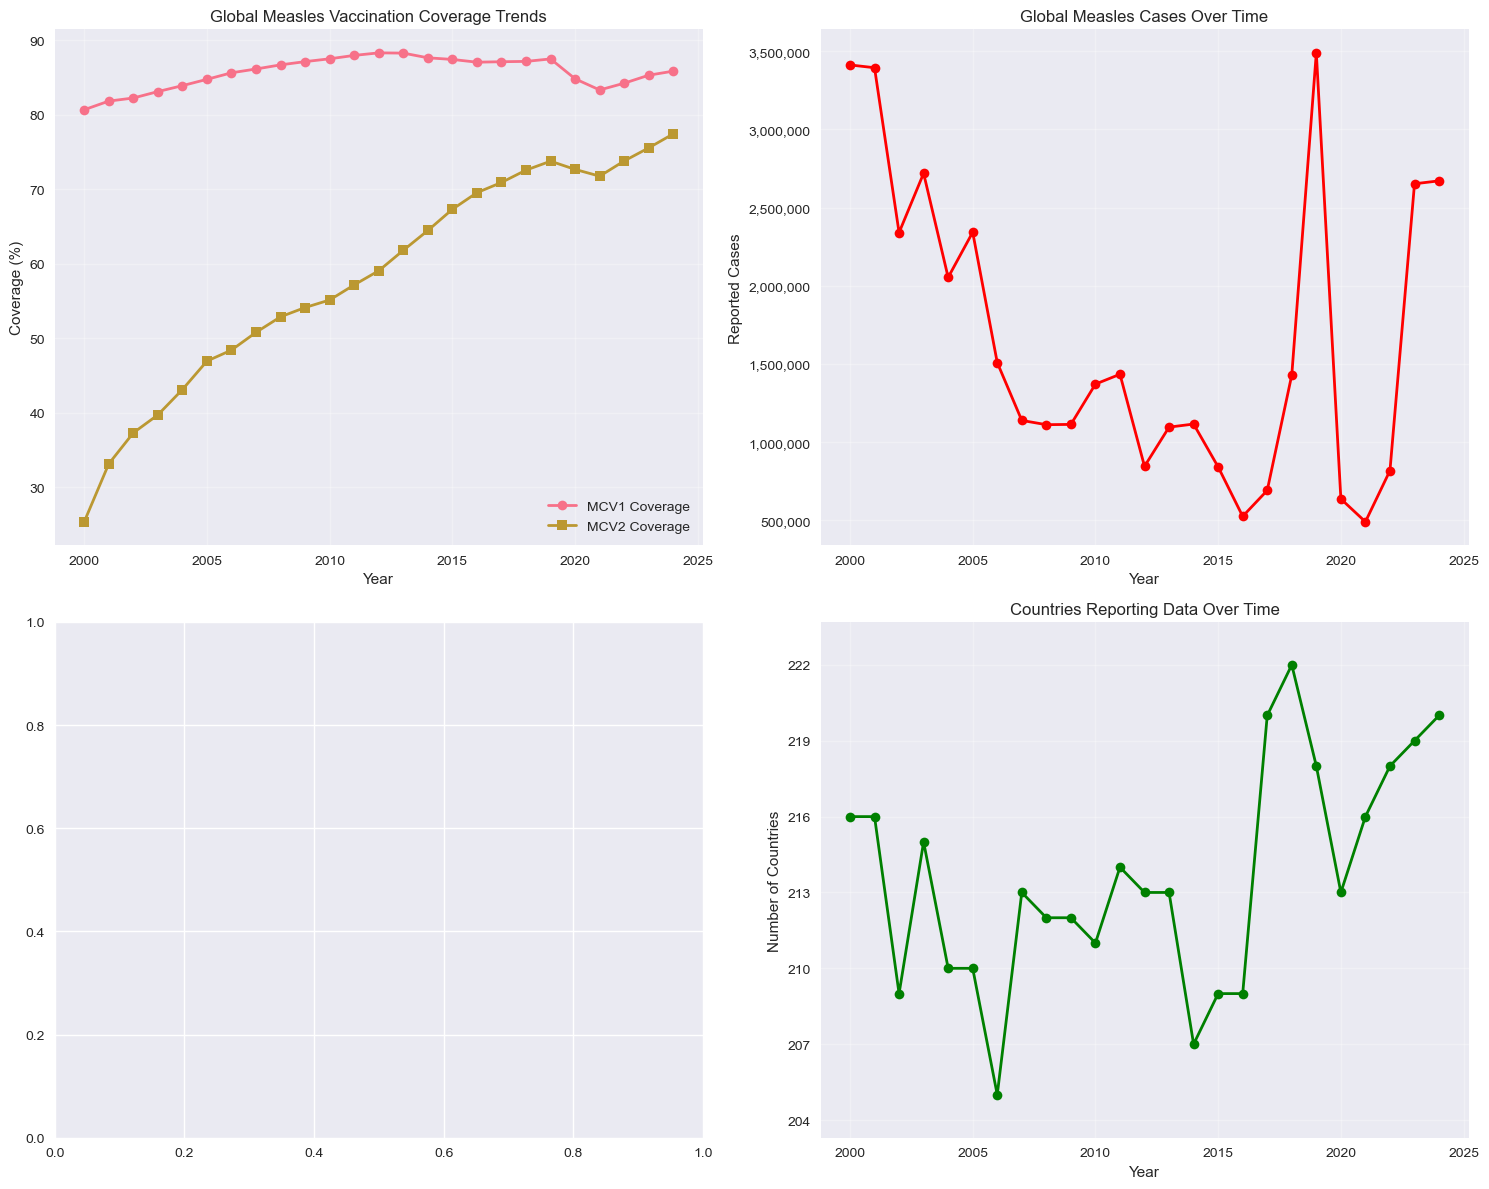

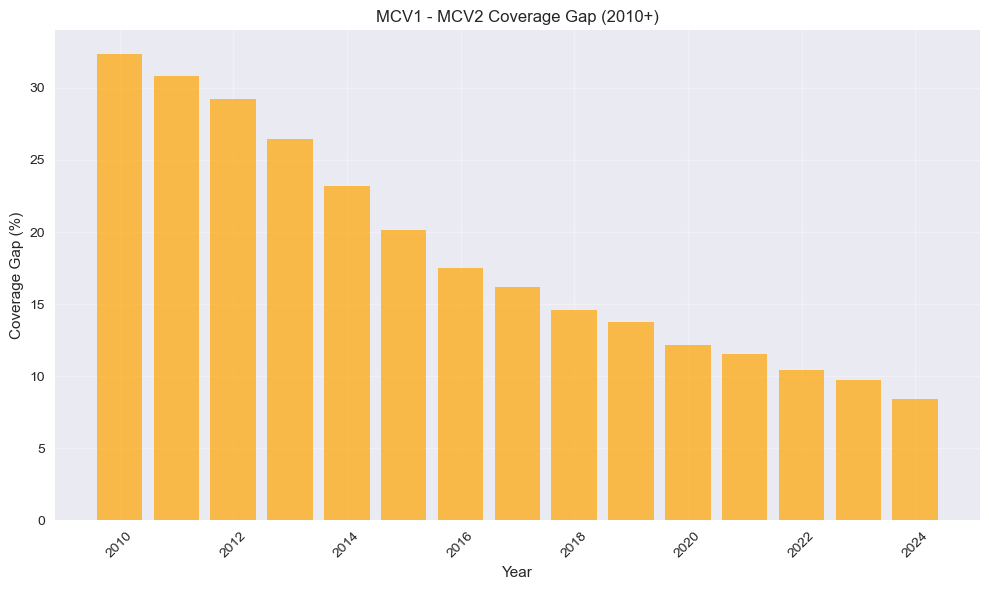

In [28]:
def create_temporal_visualizations(global_trends, recent_data, all_data):
    """Create visualizations focusing on time trends"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Global vaccination coverage trends
    axes[0,0].plot(global_trends['TimeDim'], global_trends['MCV1_Coverage'], 
                   label='MCV1 Coverage', linewidth=2, marker='o')
    axes[0,0].plot(global_trends['TimeDim'], global_trends['MCV2_Coverage'], 
                   label='MCV2 Coverage', linewidth=2, marker='s')
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Coverage (%)')
    axes[0,0].set_title('Global Measles Vaccination Coverage Trends')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Measles cases over time 
    axes[0,1].plot(global_trends['TimeDim'], global_trends['Measles_Cases'], 
                   color='red', linewidth=2, marker='o')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Reported Cases')
    axes[0,1].set_title('Global Measles Cases Over Time')
    axes[0,1].grid(True, alpha=0.3)
    
    # Format y-axis for cases to show proper scale
    if global_trends['Measles_Cases'].max() > 1000:
        from matplotlib.ticker import FuncFormatter
        def thousands_formatter(x, pos):
            return '{:,.0f}'.format(x)
        axes[0,1].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    # Plot 3: Distribution of causes of death among children aged <5 years (%) - Measles
    if 'WHS2_168' in all_data:
        death_data = all_data['WHS2_168'].copy()
        # Get latest year data for each country
        latest_death_data = death_data.sort_values('TimeDim').groupby('SpatialDim').last().reset_index()
        latest_death_data = latest_death_data[latest_death_data['NumericValue'] > 0]  # Remove zeros
        
        # Create histogram of measles death percentages
        axes[1,0].hist(latest_death_data['NumericValue'], bins=20, alpha=0.7, color='crimson', edgecolor='black')
        axes[1,0].set_xlabel('Measles Deaths as % of Under-5 Mortality')
        axes[1,0].set_ylabel('Number of Countries')
        axes[1,0].set_title('Distribution of Measles Deaths in Under-5 Mortality')
        axes[1,0].grid(True, alpha=0.3)
        
        # Add statistics to the plot
        mean_deaths = latest_death_data['NumericValue'].mean()
        median_deaths = latest_death_data['NumericValue'].median()
        axes[1,0].axvline(mean_deaths, color='red', linestyle='--', label=f'Mean: {mean_deaths:.2f}%')
        axes[1,0].axvline(median_deaths, color='blue', linestyle='--', label=f'Median: {median_deaths:.2f}%')
        axes[1,0].legend()
    
    # Plot 4: Countries reporting data over time 
    axes[1,1].plot(global_trends['TimeDim'], global_trends['Countries_Reporting'], 
                   color='green', linewidth=2, marker='o')
    axes[1,1].set_xlabel('Year')
    axes[1,1].set_ylabel('Number of Countries')
    axes[1,1].set_title('Countries Reporting Data Over Time')
    axes[1,1].grid(True, alpha=0.3)
    
    # Set proper y-axis limits for countries reporting
    max_countries = global_trends['Countries_Reporting'].max()
    min_countries = global_trends['Countries_Reporting'].min()
    buffer = (max_countries - min_countries) * 0.1
    axes[1,1].set_ylim(min_countries - buffer, max_countries + buffer)
    
    # Use integer ticks for countries
    from matplotlib.ticker import MaxNLocator
    axes[1,1].yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.show()

# Create separate figure for coverage gap (Graph 5)
def create_coverage_gap_graph(recent_data):
    """Create coverage gap visualization"""
    plt.figure(figsize=(10, 6))
    
    recent_data['Coverage_Gap'] = recent_data['MCV1_Coverage'] - recent_data['MCV2_Coverage']
    gap_by_year = recent_data.groupby('TimeDim')['Coverage_Gap'].mean().reset_index()
    gap_by_year = gap_by_year[gap_by_year['TimeDim'] >= 2010]
    
    plt.bar(gap_by_year['TimeDim'], gap_by_year['Coverage_Gap'], 
            color='orange', alpha=0.7)
    plt.xlabel('Year')
    plt.ylabel('Coverage Gap (%)')
    plt.title('MCV1 - MCV2 Coverage Gap (2010+)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create the visualizations
create_temporal_visualizations(global_trends, recent_data, all_data)
create_coverage_gap_graph(recent_data)

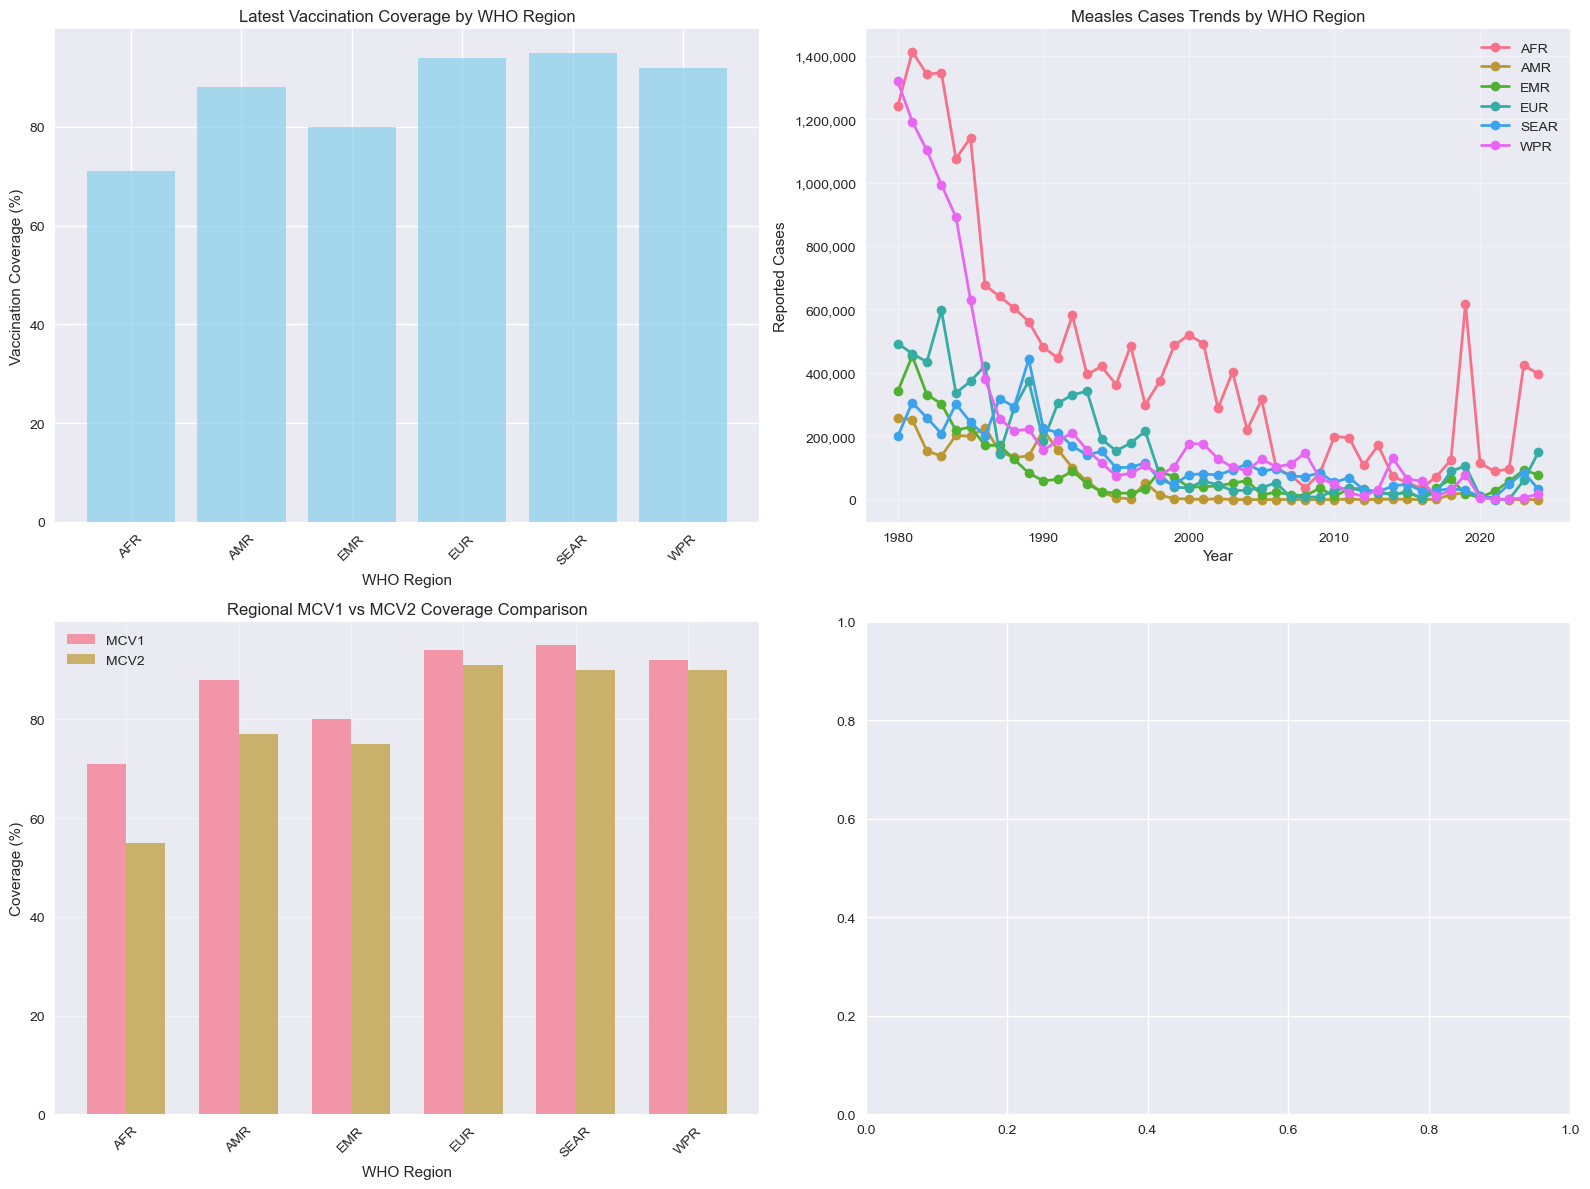

In [27]:
def create_regional_analysis(all_data, countries_df):
    """Generate regional analysis graphs"""
    
    # Extract regional data from all indicators
    regional_data = {}
    
    for indicator_code, df in all_data.items():
        if 'SpatialDimType' in df.columns and 'ParentLocation' in df.columns:
            # Filter for regional data (not country-level)
            regional_df = df[df['SpatialDimType'] == 'REGION'].copy()
            if not regional_df.empty:
                regional_data[indicator_code] = regional_df
    
    if not regional_data:
        print("No regional data found in the datasets")
        return
    
    # Create regional visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Regional MCV1 Coverage (latest year)
    if 'WHS8_110' in regional_data or 'MCV2' in regional_data:
        # Use available regional data
        regional_coverage = None
        if 'WHS8_110' in regional_data:
            regional_coverage = regional_data['WHS8_110']
        elif 'MCV2' in regional_data:
            regional_coverage = regional_data['MCV2']
        
        if regional_coverage is not None:
            latest_regional = regional_coverage.sort_values('TimeDim').groupby('SpatialDim').last().reset_index()
            axes[0,0].bar(latest_regional['SpatialDim'], latest_regional['NumericValue'], 
                         color='skyblue', alpha=0.7)
            axes[0,0].set_xlabel('WHO Region')
            axes[0,0].set_ylabel('Vaccination Coverage (%)')
            axes[0,0].set_title('Latest Vaccination Coverage by WHO Region')
            axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Regional Measles Cases Trends
    if 'WHS3_62' in regional_data:
        regional_cases = regional_data['WHS3_62']
        # Plot trends for major regions
        major_regions = ['AFR', 'AMR', 'EMR', 'EUR', 'SEAR', 'WPR']
        
        for region in major_regions:
            region_data = regional_cases[regional_cases['SpatialDim'] == region].sort_values('TimeDim')
            if not region_data.empty:
                axes[0,1].plot(region_data['TimeDim'], region_data['NumericValue'], 
                              label=region, linewidth=2, marker='o')
        
        axes[0,1].set_xlabel('Year')
        axes[0,1].set_ylabel('Reported Cases')
        axes[0,1].set_title('Measles Cases Trends by WHO Region')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Format y-axis
        if regional_cases['NumericValue'].max() > 1000:
            from matplotlib.ticker import FuncFormatter
            def thousands_formatter(x, pos):
                return '{:,.0f}'.format(x)
            axes[0,1].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    # Plot 3: Regional Coverage Comparison (MCV1 vs MCV2)
    if 'WHS8_110' in regional_data and 'MCV2' in regional_data:
        mcv1_regional = regional_data['WHS8_110'].sort_values('TimeDim').groupby('SpatialDim').last().reset_index()
        mcv2_regional = regional_data['MCV2'].sort_values('TimeDim').groupby('SpatialDim').last().reset_index()
        
        # Merge and compare
        regional_comparison = mcv1_regional[['SpatialDim', 'NumericValue']].merge(
            mcv2_regional[['SpatialDim', 'NumericValue']], 
            on='SpatialDim', 
            suffixes=('_MCV1', '_MCV2')
        )
        
        x = range(len(regional_comparison))
        width = 0.35
        
        axes[1,0].bar([i - width/2 for i in x], regional_comparison['NumericValue_MCV1'], 
                     width, label='MCV1', alpha=0.7)
        axes[1,0].bar([i + width/2 for i in x], regional_comparison['NumericValue_MCV2'], 
                     width, label='MCV2', alpha=0.7)
        
        axes[1,0].set_xlabel('WHO Region')
        axes[1,0].set_ylabel('Coverage (%)')
        axes[1,0].set_title('Regional MCV1 vs MCV2 Coverage Comparison')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(regional_comparison['SpatialDim'], rotation=45)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Regional Measles Death Distribution
    if 'WHS2_168' in regional_data:
        regional_deaths = regional_data['WHS2_168']
        latest_regional_deaths = regional_deaths.sort_values('TimeDim').groupby('SpatialDim').last().reset_index()
        
        axes[1,1].bar(latest_regional_deaths['SpatialDim'], latest_regional_deaths['NumericValue'],
                     color='crimson', alpha=0.7)
        axes[1,1].set_xlabel('WHO Region')
        axes[1,1].set_ylabel('Measles Deaths (% of Under-5 Mortality)')
        axes[1,1].set_title('Measles Deaths in Under-5 Mortality by Region')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return regional_data

# Generate regional analysis
regional_results = create_regional_analysis(all_data, countries_df)

Countries with 10+ years of data: 205


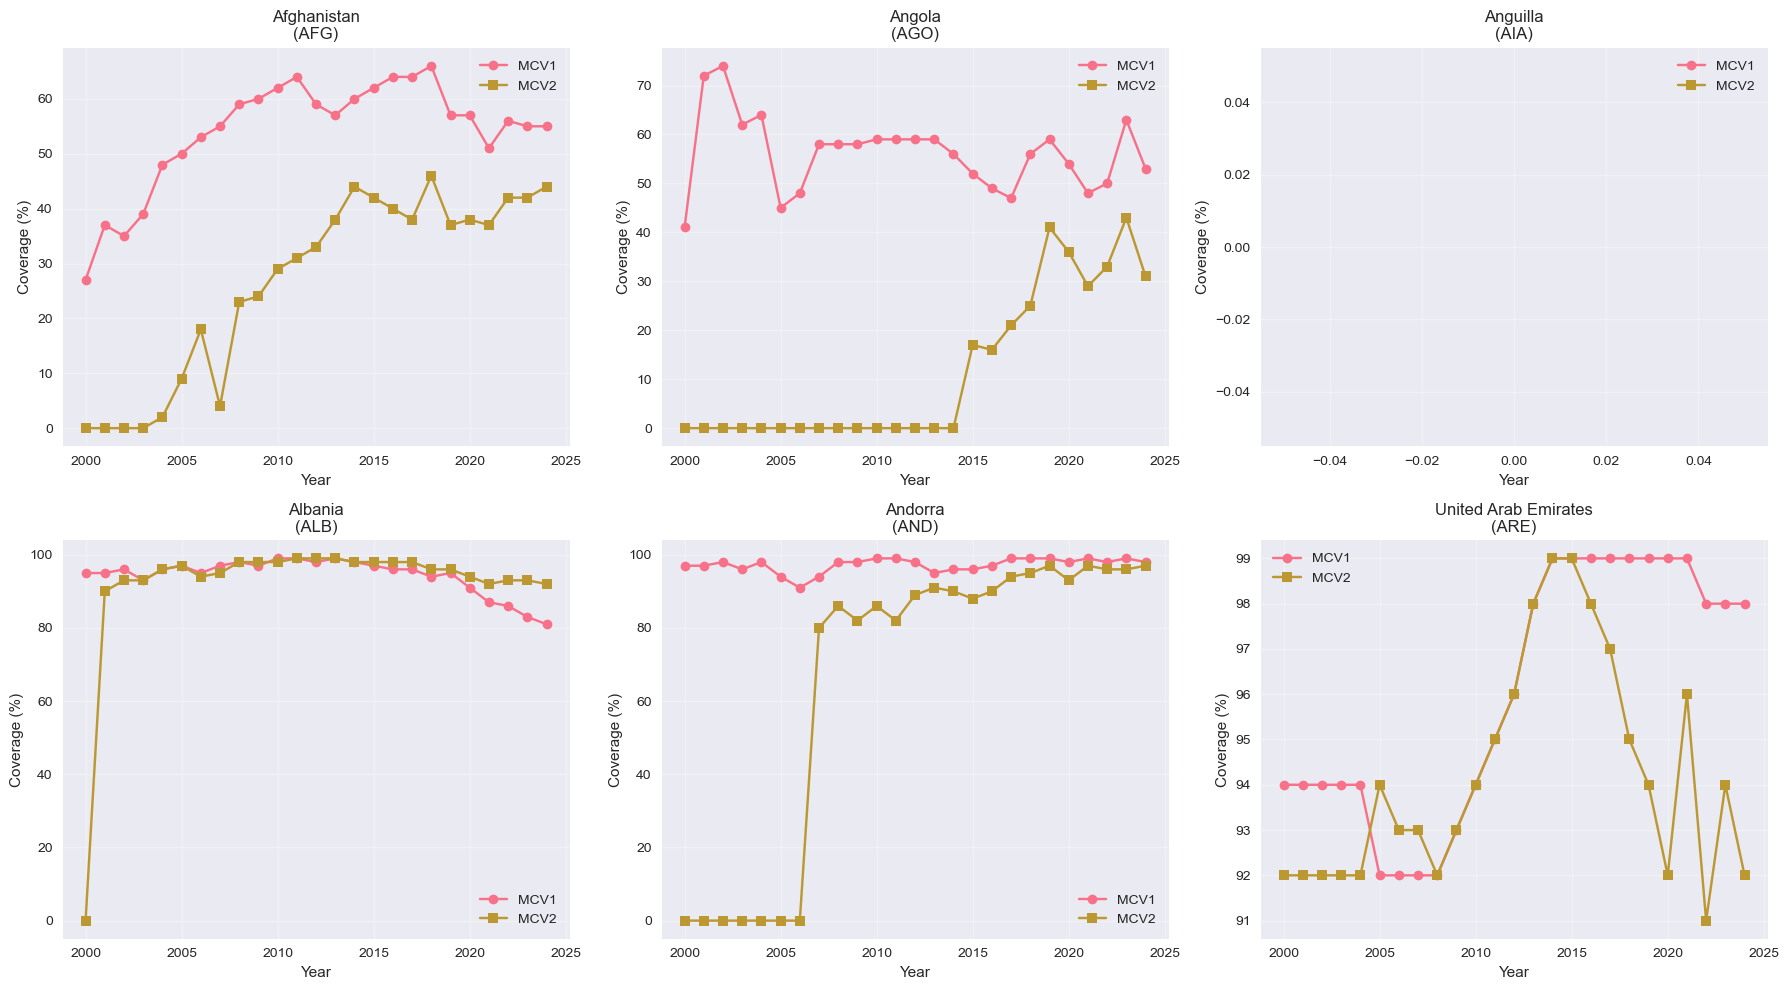

In [17]:
def country_level_analysis(df):
    """Analyze specific country trends"""
    
    # Get countries with complete time series
    country_years = df.groupby(['SpatialDim', 'CountryName']).agg({
        'TimeDim': ['min', 'max', 'nunique']
    }).reset_index()
    
    country_years.columns = ['SpatialDim', 'CountryName', 'First_Year', 'Last_Year', 'Years_Reported']
    
    # Find countries with long time series
    long_series = country_years[country_years['Years_Reported'] >= 10]
    print(f"Countries with 10+ years of data: {len(long_series)}")
    
    # Analyze specific countries
    sample_countries = long_series.head(6)['SpatialDim'].tolist()
    
    # Plot trends for sample countries
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, country_code in enumerate(sample_countries):
        if i >= len(axes):
            break
            
        country_data = df[df['SpatialDim'] == country_code].sort_values('TimeDim')
        country_name = country_data['CountryName'].iloc[0] if 'CountryName' in country_data.columns else country_code
        
        if not country_data.empty:
            axes[i].plot(country_data['TimeDim'], country_data['MCV1_Coverage'], 
                        label='MCV1', marker='o')
            axes[i].plot(country_data['TimeDim'], country_data['MCV2_Coverage'], 
                        label='MCV2', marker='s')
            axes[i].set_title(f'{country_name}\n({country_code})')
            axes[i].set_xlabel('Year')
            axes[i].set_ylabel('Coverage (%)')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return long_series

long_series_countries = country_level_analysis(recent_data)

In [18]:
def generate_insights(global_trends, df):
    """Generate key insights from the temporal analysis"""
    
    print("=== KEY INSIGHTS ===")
    
    # Latest global coverage
    latest_year = global_trends['TimeDim'].max()
    latest_data = global_trends[global_trends['TimeDim'] == latest_year].iloc[0]
    
    print(f"Latest year with data: {latest_year}")
    print(f"Global MCV1 Coverage: {latest_data['MCV1_Coverage']:.1f}%")
    print(f"Global MCV2 Coverage: {latest_data['MCV2_Coverage']:.1f}%")
    print(f"Global Measles Cases: {latest_data['Measles_Cases']:,.0f}")
    
    # Coverage gap analysis
    coverage_gap = latest_data['MCV1_Coverage'] - latest_data['MCV2_Coverage']
    print(f"Global MCV1-MCV2 Coverage Gap: {coverage_gap:.1f}%")
    
    # Trend analysis (last 10 years)
    recent_10yr = global_trends[global_trends['TimeDim'] >= latest_year - 10]
    mcv1_trend = recent_10yr['MCV1_Coverage'].pct_change().mean() * 100
    mcv2_trend = recent_10yr['MCV2_Coverage'].pct_change().mean() * 100
    
    print(f"\n10-Year Trends (annual % change):")
    print(f"MCV1 Coverage: {mcv1_trend:+.2f}%")
    print(f"MCV2 Coverage: {mcv2_trend:+.2f}%")
    
    # Countries with improving/declining coverage
    country_trends = df.groupby('SpatialDim').apply(
        lambda x: x['MCV1_Coverage'].iloc[-1] - x['MCV1_Coverage'].iloc[0] 
        if len(x) >= 2 else None
    ).dropna()
    
    improving = country_trends[country_trends > 10]
    declining = country_trends[country_trends < -10]
    
    print(f"\nCountries with significant improvements (>10%): {len(improving)}")
    print(f"Countries with significant declines (>10%): {len(declining)}")

generate_insights(global_trends, recent_data)

=== KEY INSIGHTS ===
Latest year with data: 2024
Global MCV1 Coverage: 85.9%
Global MCV2 Coverage: 77.5%
Global Measles Cases: 2,671,114
Global MCV1-MCV2 Coverage Gap: 8.4%

10-Year Trends (annual % change):
MCV1 Coverage: -0.20%
MCV2 Coverage: +1.87%

Countries with significant improvements (>10%): 61
Countries with significant declines (>10%): 22


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_17296\188544065.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_trends = df.groupby('SpatialDim').apply(
